# An Introduction to JAX

**Prepared for the Bank of Portugal Computational Economics Course (Oct 2025)**

**Author:** [John Stachurski](https://johnstachurski.net)

# GPU

This lecture provides a short introduction to [Google JAX](https://github.com/google/jax).

Let’s see if we have an active GPU:

In [1]:
!nvidia-smi

Thu Oct  9 07:36:59 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   55C    P8             12W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## JAX as a NumPy Replacement

One way to use JAX is as a plug-in NumPy replacement. Let’s look at the
similarities and differences.

### Similarities

The following import is standard, replacing `import numpy as np`:

In [2]:
import jax
import jax.numpy as jnp

Now we can use `jnp` in place of `np` for the usual array operations:

In [3]:
a = jnp.asarray((1.0, 3.2, -1.5))

In [4]:
print(a)

[ 1.   3.2 -1.5]


In [5]:
print(jnp.sum(a))

2.6999998


In [6]:
print(jnp.mean(a))

0.9


In [7]:
print(jnp.dot(a, a))

13.490001


However, the array object `a` is not a NumPy array:

In [8]:
a

Array([ 1. ,  3.2, -1.5], dtype=float32)

In [9]:
type(a)

jaxlib.xla_extension.ArrayImpl

Even scalar-valued maps on arrays return JAX arrays.

In [10]:
jnp.sum(a)

Array(2.6999998, dtype=float32)

JAX arrays are also called “device arrays,” where term “device” refers to a
hardware accelerator (GPU or TPU).

(In the terminology of GPUs, the “host” is the machine that launches GPU operations, while the “device” is the GPU itself.)

Operations on higher dimensional arrays are also similar to NumPy:

In [11]:
A = jnp.ones((2, 2))
B = jnp.identity(2)
A @ B

Array([[1., 1.],
       [1., 1.]], dtype=float32)

In [12]:
from jax.numpy import linalg

In [13]:
linalg.inv(B)   # Inverse of identity is identity

Array([[1., 0.],
       [0., 1.]], dtype=float32)

In [14]:
linalg.eigh(B)  # Computes eigenvalues and eigenvectors

EighResult(eigenvalues=Array([0.99999994, 0.99999994], dtype=float32), eigenvectors=Array([[1., 0.],
       [0., 1.]], dtype=float32))

### Differences

One difference between NumPy and JAX is that JAX currently uses 32 bit floats by default.

This is standard for GPU computing and can lead to significant speed gains with small loss of precision.

However, for some calculations precision matters.  In these cases 64 bit floats can be enforced via the command

In [15]:
jax.config.update("jax_enable_x64", True)

Let’s check this works:

In [16]:
jnp.ones(3)

Array([1., 1., 1.], dtype=float64)

As a NumPy replacement, a more significant difference is that arrays are treated as **immutable**.

For example, with NumPy we can write

In [17]:
import numpy as np
a = np.linspace(0, 1, 3)
a

array([0. , 0.5, 1. ])

and then mutate the data in memory:

In [18]:
a[0] = 1
a

array([1. , 0.5, 1. ])

In JAX this fails:

In [19]:
a = jnp.linspace(0, 1, 3)
a

Array([0. , 0.5, 1. ], dtype=float64)

In [20]:
# a[0] = 1  # If you uncomment and run this it will fail

In line with immutability, JAX does not support inplace operations:

In [21]:
a = np.array((2, 1))
a.sort()
a

array([1, 2])

In [22]:
a = jnp.array((2, 1))
a_new = a.sort()
a, a_new

(Array([2, 1], dtype=int64), Array([1, 2], dtype=int64))

The designers of JAX chose to make arrays immutable because JAX uses a
functional programming style.  More on this below.

However, JAX provides a functionally pure equivalent of in-place array modification
using the [`at` method](https://docs.jax.dev/en/latest/_autosummary/jax.numpy.ndarray.at.html).

In [23]:
a = jnp.linspace(0, 1, 3)
id(a)

307423296

In [24]:
a

Array([0. , 0.5, 1. ], dtype=float64)

Applying `at[0].set(1)` returns a new copy of `a` with the first element set to 1

In [25]:
a = a.at[0].set(1)
a

Array([1. , 0.5, 1. ], dtype=float64)

Inspecting the identifier of `a` shows that it has been reassigned

In [26]:
id(a)

317203200

## Random Numbers

Random numbers are also a bit different in JAX, relative to NumPy.  Typically, in JAX, the state of the random number generator needs to be controlled explicitly.

In [27]:
import jax.random as random

First we produce a key, which seeds the random number generator.

In [28]:
key = random.PRNGKey(1)

In [29]:
type(key)

jaxlib.xla_extension.ArrayImpl

In [30]:
print(key)

[0 1]


Now we can use the key to generate some random numbers:

In [31]:
x = random.normal(key, (3, 3))
x

Array([[-1.18428442, -0.11617041,  0.17269028],
       [ 0.95730718, -0.83295415,  0.69080517],
       [ 0.07545021, -0.7645271 , -0.05064539]], dtype=float64)

If we use the same key again, we initialize at the same seed, so the random numbers are the same:

In [32]:
random.normal(key, (3, 3))

Array([[-1.18428442, -0.11617041,  0.17269028],
       [ 0.95730718, -0.83295415,  0.69080517],
       [ 0.07545021, -0.7645271 , -0.05064539]], dtype=float64)

To produce a (quasi-) independent draw, best practice is to “split” the existing key:

In [33]:
key, subkey = random.split(key)

In [34]:
random.normal(key, (3, 3))

Array([[ 1.09221959,  0.33192176, -0.90184197],
       [-1.37815779,  0.43052577,  1.6068202 ],
       [ 0.04053753, -0.78732842,  1.75917181]], dtype=float64)

In [35]:
random.normal(subkey, (3, 3))

Array([[ 0.7158846 ,  0.03955972,  0.71127682],
       [-0.40080158, -0.91609481,  0.23713062],
       [ 0.85253995, -0.80972695,  1.79431941]], dtype=float64)

The function below produces `k` (quasi-) independent random `n x n` matrices using this procedure.

In [36]:
def gen_random_matrices(key, n, k):
    matrices = []
    for _ in range(k):
        key, subkey = random.split(key)
        matrices.append(random.uniform(subkey, (n, n)))
    return matrices

In [37]:
matrices = gen_random_matrices(key, 2, 2)
for A in matrices:
    print()
    print(A)


[[0.29202993 0.43545993]
 [0.73730956 0.3796823 ]]

[[0.08823494 0.3358791 ]
 [0.72669531 0.82647633]]


## JIT compilation

The JAX just-in-time (JIT) compiler accelerates logic within functions by fusing linear
algebra operations into a single optimized kernel that the host can
launch on the GPU / TPU (or CPU if no accelerator is detected).

### A first example

To see the JIT compiler in action, consider the following function.

In [38]:
def f(x):
    a = 3*x + jnp.sin(x) + jnp.cos(x**2) - jnp.cos(2*x) + 6*x + 10*x**2
    return jnp.sum(a)

Let’s build an array to call the function on.

In [39]:
n = 50_000_000
x = jnp.ones(n)

How long does the function take to execute?

In [40]:
%time f(x).block_until_ready()

CPU times: user 281 ms, sys: 4.58 ms, total: 286 ms
Wall time: 429 ms


Array(1.03989601e+09, dtype=float64)

The code doesn’t run as fast as we might hope, given that it’s running on a GPU.

But if we run it a second time it becomes much faster:

In [41]:
%time f(x).block_until_ready()

CPU times: user 5.6 ms, sys: 0 ns, total: 5.6 ms
Wall time: 128 ms


Array(1.03989601e+09, dtype=float64)

This is because the built in functions like `jnp.cos` are JIT compiled and the
first run includes compile time.

Why would JAX want to JIT-compile built in functions like `jnp.cos` instead of
just providing pre-compiled versions, like NumPy?

The reason is that the JIT compiler can specialize on the *size* of the array
being used, which is helpful for parallelization.

For example, in running the code above, the JIT compiler produced a version of `jnp.cos` that is
specialized to floating point arrays of size `n = 50_000_000`.

We can check this by calling `f` with a new array of different size.

In [42]:
m = 50_000_001
y = jnp.ones(m)

In [43]:
%time f(y).block_until_ready()

CPU times: user 251 ms, sys: 13.5 ms, total: 264 ms
Wall time: 386 ms


Array(1.03989603e+09, dtype=float64)

Notice that the execution time increases, because now new versions of
the built-ins like `jnp.cos` are being compiled, specialized to the new array
size.

If we run again, the code is dispatched to the correct compiled version and we
get faster execution.

In [44]:
%time f(y).block_until_ready()

CPU times: user 5.29 ms, sys: 1.27 ms, total: 6.56 ms
Wall time: 111 ms


Array(1.03989603e+09, dtype=float64)

The compiled versions for the previous array size are still available in memory
too, and the following call is dispatched to the correct compiled code.

In [45]:
%time f(x).block_until_ready()

CPU times: user 3.96 ms, sys: 2.07 ms, total: 6.03 ms
Wall time: 128 ms


Array(1.03989601e+09, dtype=float64)

### Compiling the outer function

We can do even better if we manually JIT-compile the outer function.

In [46]:
f_jit = jax.jit(f)   # target for JIT compilation

Let’s run once to compile it:

In [47]:
f_jit(x)

Array(1.03989601e+09, dtype=float64)

And now let’s time it.

In [48]:
%timeit f_jit(x).block_until_ready()

29.8 ms ± 127 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Note the speed gain.

This is because the array operations are fused and no intermediate arrays are created.

Incidentally, a more common syntax when targetting a function for the JIT
compiler is

In [49]:
@jax.jit
def f(x):
    a = 3*x + jnp.sin(x) + jnp.cos(x**2) - jnp.cos(2*x) - x**2 * 0.4 * x**1.5
    return jnp.sum(a)

## Functional Programming

From JAX’s documentation:

*When walking about the countryside of Italy, the people will not hesitate to tell you that JAX has “una anima di pura programmazione funzionale”.*

In other words, JAX assumes a functional programming style.

The major implication is that JAX functions should be pure.

A pure function will always return the same result if invoked with the same inputs.

In particular, a pure function has

- no dependence on global variables and  
- no side effects  


JAX will not usually throw errors when compiling impure functions but execution becomes unpredictable.

Here’s an illustration of this fact, using global variables:

In [50]:
a = 1  # global

@jax.jit
def f(x):
    return a + x

In [51]:
x = jnp.ones(5)

In [52]:
f(x)

Array([2., 2., 2., 2., 2.], dtype=float64)

In the code above, the global value `a=1` is fused into the jitted function.

Even if we change `a`, the output of `f` will not be affected — as long as the same compiled version is called.

In [53]:
a = 42

In [54]:
f(x)

Array([2., 2., 2., 2., 2.], dtype=float64)

But now it changes:  Why?

In [55]:
x = jnp.ones(3)

In [56]:
f(x)

Array([43., 43., 43.], dtype=float64)

Moral of the story: write pure functions when using JAX!

## Gradients

JAX can use automatic differentiation to compute gradients.

This can be extremely useful for optimization and solving nonlinear systems.

We will see significant applications later in this lecture series.

For now, here’s a very simple illustration involving the function

In [57]:
def f(x):
    return (x**2) / 2

Let’s take the derivative:

In [58]:
f_prime = jax.grad(f)

In [59]:
f_prime(10.0)

Array(10., dtype=float64, weak_type=True)

Let’s plot the function and derivative, noting that $ f'(x) = x $.

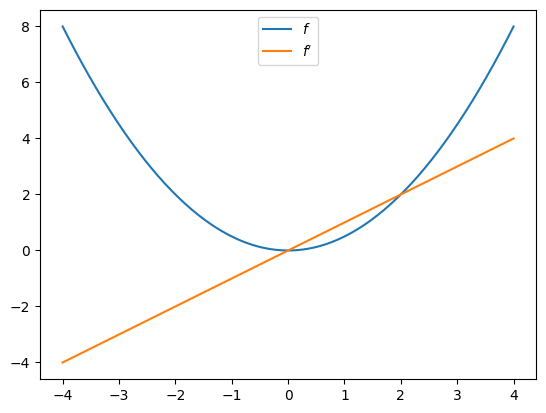

In [60]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
x_grid = jnp.linspace(-4, 4, 200)
ax.plot(x_grid, f(x_grid), label="$f$")
ax.plot(x_grid, [f_prime(x) for x in x_grid], label="$f'$")
ax.legend(loc='upper center')
plt.show()

We defer further exploration of automatic differentiation with JAX until [Adventures with Autodiff](https://jax.quantecon.org/autodiff.html).

## Writing vectorized code

Writing fast JAX code requires shifting repetitive tasks from loops to array processing operations, so that the JAX compiler can easily understand the whole operation and generate more efficient machine code.

This procedure is called **vectorization** or **array programming**, and will be familiar to anyone who has used NumPy or MATLAB.

In most ways, vectorization is the same in JAX as it is in NumPy.

But there are also some differences, which we highlight here.

As a running example, consider the function

$$
f(x,y) = \frac{\cos(x^2 + y^2)}{1 + x^2 + y^2}
$$

Suppose that we want to evaluate this function on a square grid of $ x $ and $ y $ points and then plot it.

To clarify, here is the slow `for` loop version.

In [61]:
@jax.jit
def f(x, y):
    return jnp.cos(x**2 + y**2) / (1 + x**2 + y**2)

n = 80
x = jnp.linspace(-2, 2, n)
y = x

z_loops = np.empty((n, n))

In [63]:
%%time
for i in range(n):
    for j in range(n):
        z_loops[i, j] = f(x[i], y[j])

CPU times: user 10.7 s, sys: 1.97 s, total: 12.6 s
Wall time: 8.05 s


Even for this very small grid, the run time is extremely slow.

(Notice that we used a NumPy array for `z_loops` because we wanted to write to it.)

OK, so how can we do the same operation in vectorized form?

If you are new to vectorization, you might guess that we can simply write

In [64]:
z_bad = f(x, y)

But this gives us the wrong result because JAX doesn’t understand the nested for loop.

In [65]:
z_bad.shape

(80,)

Here is what we actually wanted:

In [66]:
z_loops.shape

(80, 80)

To get the right shape and the correct nested for loop calculation, we can use a `meshgrid` operation designed for this purpose:

In [67]:
x_mesh, y_mesh = jnp.meshgrid(x, y)

Now we get what we want and the execution time is very fast.

In [68]:
%%time
z_mesh = f(x_mesh, y_mesh).block_until_ready()

CPU times: user 49 ms, sys: 1.95 ms, total: 51 ms
Wall time: 79.8 ms


Let’s run again to eliminate compile time.

In [69]:
%%time
z_mesh = f(x_mesh, y_mesh).block_until_ready()

CPU times: user 1.1 ms, sys: 16 µs, total: 1.11 ms
Wall time: 708 µs


Let’s confirm that we got the right answer.

In [70]:
jnp.allclose(z_mesh, z_loops)

Array(True, dtype=bool)

Now we can set up a serious grid and run the same calculation (on the larger grid) in a short amount of time.

In [71]:
n = 6000
x = jnp.linspace(-2, 2, n)
y = x
x_mesh, y_mesh = jnp.meshgrid(x, y)

In [82]:
%%time
z_mesh = f(x_mesh, y_mesh).block_until_ready()

CPU times: user 1.45 ms, sys: 0 ns, total: 1.45 ms
Wall time: 28.3 ms


Let’s run again to get rid of compile time.

In [83]:
%%timeit
z_mesh = f(x_mesh, y_mesh).block_until_ready()

11.2 ms ± 103 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


But there is one problem here: the mesh grids use a lot of memory.

In [84]:
x_mesh.nbytes + y_mesh.nbytes

576000000

By comparison, the flat array `x` is just

In [85]:
x.nbytes  # and y is just a pointer to x

48000

This extra memory usage can be a big problem in actual research calculations.

So let’s try a different approach using [jax.vmap](https://jax.readthedocs.io/en/latest/_autosummary/jax.vmap.html)

First we vectorize `f` in `y`.

In [86]:
f_vec_y = jax.vmap(f, in_axes=(None, 0))

In the line above, `(None, 0)` indicates that we are vectorizing in the second argument, which is `y`.

Next, we vectorize in the first argument, which is `x`.

In [87]:
f_vec = jax.vmap(f_vec_y, in_axes=(0, None))

With this construction, we can now call the function $ f $ on flat (low memory) arrays.

In [88]:
%%time
z_vmap = f_vec(x, y).block_until_ready()

CPU times: user 2.59 ms, sys: 99 µs, total: 2.69 ms
Wall time: 25.8 ms


We run it again to eliminate compile time.

In [89]:
%%timeit
z_vmap = f_vec(x, y).block_until_ready()

10.1 ms ± 403 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


The execution time is essentially the same as the mesh operation but we are using much less memory.

And we produce the correct answer:

In [90]:
jnp.allclose(z_vmap, z_mesh)

Array(True, dtype=bool)

## Exercises

In the Exercise section of [a lecture on Numba and parallelization](https://python-programming.quantecon.org/parallelization.html), we use Monte Carlo to price a European call option.

The code was accelerated by Numba-based multithreading.

Try writing a version of this operation for JAX, using all the same
parameters.

If you are running your code on a GPU, you should be able to achieve
significantly faster execution.

In [112]:
# @title Texto de título predefinido
# Put your solution here

import jax
import jax.numpy as jnp
import jax.random as random
# import numpy as np # Import numpy for np.log

M = 10_000_000

n, β, K = 20, 0.99, 100
μ, ρ, ν, S0, h0 = 0.0001, 0.1, 0.001, 10, 0

key = random.PRNGKey(1)

@jax.jit
def compute_call_price_parallel(key, β=β,
                                μ=μ,
                                S0=S0,
                                h0=h0,
                                K=K,
                                n=n,
                                ρ=ρ,
                                ν=ν,
                                M=M):
    # For each sample path

    s=jnp.full(M, jnp.log(S0)) # Use np.log for the initial value
    h=jnp.full(M, h0)

    for t in range(n):
            key, subkey = random.split(key) # Split the key
            Z1, Z2 = random.normal(subkey, (2, M)) # Generate two sets of random numbers
            s = s + μ + jnp.exp(h) * Z1
            h = ρ * h + ν * Z2

    expectation = jnp.mean(jnp.maximum(jnp.exp(s) - K, 0))

    return β**n * expectation / M

# Pass the key to the function
aux = compute_call_price_parallel(key)

XlaRuntimeError: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 15600001472 bytes.

In [ ]:
aux

In [ ]:
for _ in range(20):
    print("Solution below!")

Solution below!
Solution below!
Solution below!
Solution below!
Solution below!
Solution below!
Solution below!
Solution below!
Solution below!
Solution below!
Solution below!
Solution below!
Solution below!
Solution below!
Solution below!
Solution below!
Solution below!
Solution below!
Solution below!
Solution below!


In [ ]:
M = 10_000_000

n, β, K = 20, 0.99, 100
μ, ρ, ν, S0, h0 = 0.0001, 0.1, 0.001, 10, 0

@jax.jit
def compute_call_price_jax(β=β,
                           μ=μ,
                           S0=S0,
                           h0=h0,
                           K=K,
                           n=n,
                           ρ=ρ,
                           ν=ν,
                           M=M,
                           key=jax.random.PRNGKey(1)):

    s = jnp.full(M, np.log(S0))
    h = jnp.full(M, h0)
    for t in range(n):
        key, subkey = jax.random.split(key)
        Z = jax.random.normal(subkey, (2, M))
        s = s + μ + jnp.exp(h) * Z[0, :]
        h = ρ * h + ν * Z[1, :]
    expectation = jnp.mean(jnp.maximum(jnp.exp(s) - K, 0))

    return β**n * expectation

Let’s run it once to compile it:

In [ ]:
%%time
compute_call_price_jax().block_until_ready()

CPU times: user 9.44 s, sys: 390 ms, total: 9.83 s
Wall time: 9.57 s


Array(699495.97040563, dtype=float64)

And now let’s time it:

In [ ]:
%%time
compute_call_price_jax().block_until_ready()

CPU times: user 2.92 ms, sys: 95 μs, total: 3.01 ms
Wall time: 225 ms


Array(699495.97040563, dtype=float64)